In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
#import tqdm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle

from tqdm import tqdm
import os
con=sqlite3.connect(r'C:\Users\Ram Nikhilesh\Desktop\ai class\csv files\amazon fine food review\database.sqlite')
filter_data=pd.read_sql_query("""select * from Reviews""",con)
filter_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
con=sqlite3.connect(r'C:\Users\Ram Nikhilesh\Desktop\ai class\csv files\amazon fine food review\database.sqlite')

filter_data=pd.read_sql_query("""select * from Reviews where Score != 3""",con)
def partition(x):
    if x<3:
        return 0;
    return 1;
actualscore=filter_data['Score']
positivenegative=actualscore.map(partition)
filter_data['Score']=positivenegative
print(filter_data.shape)
filter_data.head(3)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
final=filter_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first')
final.shape

(364173, 10)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
print(final.shape)

(364171, 10)


In [7]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [8]:
stop = set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
#print(stop)
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] 
    all_negative_words=[] 
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentences=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha())&(len(cleaned_words)>2)):
                    if(cleaned_words.lower()not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentences.append(s);
                        if(final['Score'].values)[i] == 1:
                            all_positive_words.append(s)
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
                        
        str1=b" ".join(filtered_sentences)
        final_string.append(str1)
        i+=1
    final['CleanedText']=final_string
    final['CleanedText']=final['CleanedText'].str.decode('utf-8')
    
    
  

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [14:19<00:00, 423.57it/s]


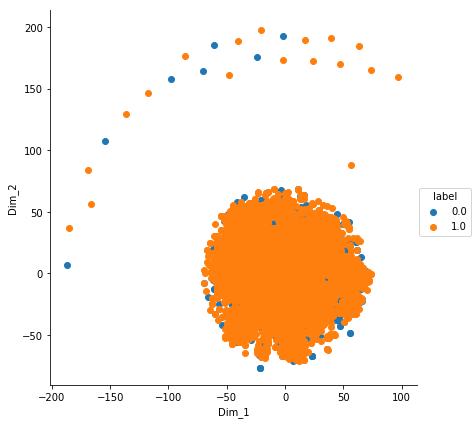

In [8]:
from sklearn.manifold import TSNE
final_=final['CleanedText']
#print(final.head(20))
final_5000=final_[0:5000]
score_=final['Score']
score_5000=score_[0:5000]
import numpy as np
import seaborn as sn
count_vector=CountVectorizer()

#BOW
final_counts=count_vector.fit_transform(final_5000)
s_5000=final_counts.toarray() 
# print(final_counts.get_shape())
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=3000)
tsne_data = model.fit_transform(s_5000)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
#print(tsne_data.get_shape())
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();  

# Observation of BOW
we took perplexity as 10 and no of iterations as 3000. 

we can observe that all of the positive words and negative words are mixed together and only some are seperated

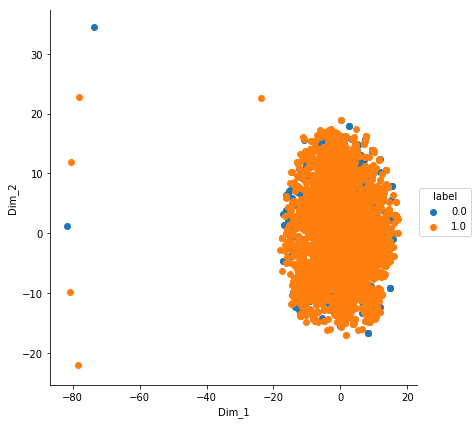

In [16]:
from sklearn.manifold import TSNE
final_=final['CleanedText']
#print(final.head(20))
final_5000=final_[0:5000]
score_=final['Score']
score_5000=score_[0:5000]
import numpy as np
import seaborn as sn
count_vector=CountVectorizer()

#BOW
final_counts=count_vector.fit_transform(final_5000)
s_5000=final_counts.toarray() 
# print(final_counts.get_shape())
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=2000)
tsne_data = model.fit_transform(s_5000)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
#print(tsne_data.get_shape())
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();  

# Observation
In this graph we took perplexity as 10 and no of iterations as 2000.

There is no much difference from the above graph what we got only some words got seperated.

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 8603)


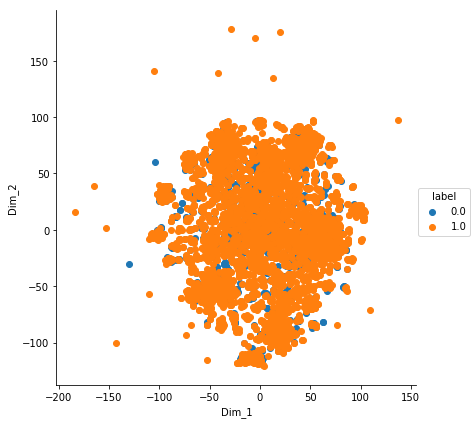

In [9]:
#TF-IDF

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(final_5000)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
t_5000=final_tf_idf.toarray()
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=2000)
tsne_data = model.fit_transform(t_5000)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();    








# Observatio of Tf-IDf
In the above graph we took perplexity as 10 and no of iterations as 2000.

we got results similar to BOW most of the words are similar 


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 8603)


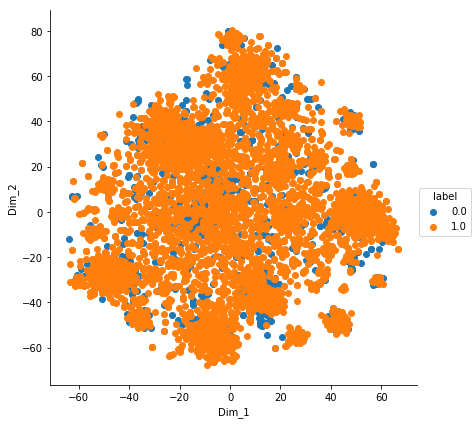

In [17]:
#TF-IDF

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(final_5000)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
t_5000=final_tf_idf.toarray()
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(t_5000)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();    








# Observation
Here we took perplexity as 50 and no of iterations as 3000.

here also we are getting same results.


In [10]:
i=0
list_of_sent=[]
for sent in final_5000:
    list_of_sent.append(sent.split())

In [11]:
print(final_5000.values[0])
print("*****************************************************************")
print(list_of_sent[0])

bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better
*****************************************************************
['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


In [12]:
from gensim.models import Word2Vec

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [13]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  2963


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 783.83it/s]


5000
50


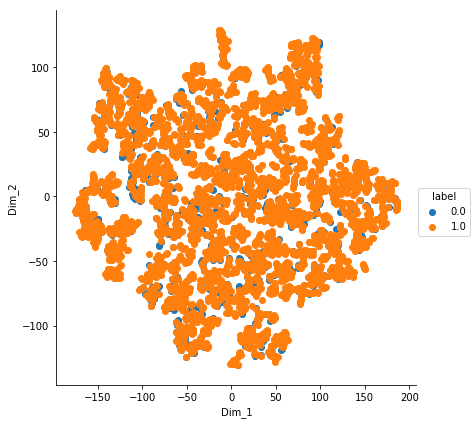

In [14]:
# average word2vec 
sent_vectors = []; 
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();

# Observation of avg Word2vec
here we took perplexity as 10 and no of iterations as 5000.

But here also we are getting same results as above graphs.

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 738.89it/s]


5000
50


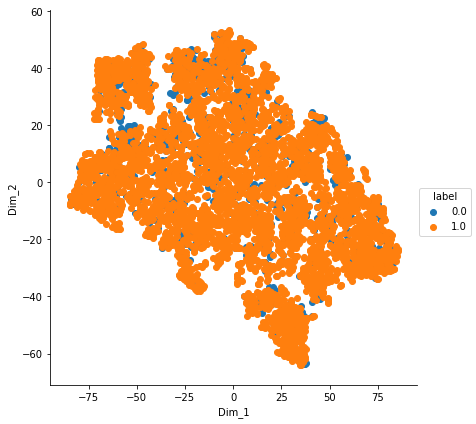

In [18]:
# average word2vec 
sent_vectors = []; 
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();

# Observation

This time we took perplexity as 10 and no of iterations as 3000.

But we are getting same results.


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 647.15it/s]


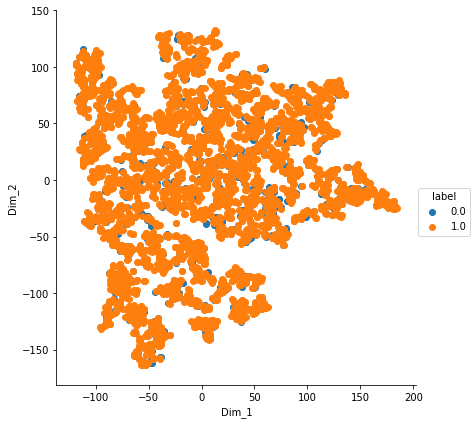

In [15]:
# TF-IDF weighted Word2Vec


model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_5000)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();    


# Observation of TF-IDF weig Word2vec
Here we took perplexity as 10 and no of iterations as 5000.

Here also we are getting similar to above graphs.


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 612.21it/s]


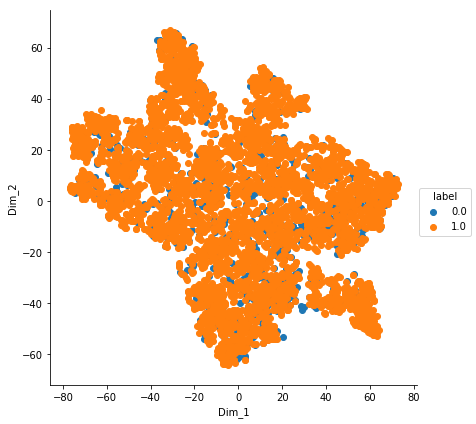

In [19]:
# TF-IDF weighted Word2Vec


model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_5000)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 
tfidf_sent_vectors = []
row=0;
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(50) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=3000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, score_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show();    


# Observation
Here we took perplexity as 50 and no of iterations as 5000.

But here also we are getting similar results.